In [1]:
#本地文件读取数据

from jaqs_fxdayu.data import DataView
from jaqs_fxdayu.data import LocalDataService
from jaqs_fxdayu.util import dp

ds = LocalDataService(r'E://股票因子数据/data')
start = 20170101
end = 20180425

factor = ['index_member','close','pb','float_mv','net_profit','pe','volume','capital_stk','tot_profit','less_int_exp','int_income','total_liab','end_bal_cash','tot_assets']
check_factor = ','.join(factor)

dv_props = {'start_date': start, 'end_date': end, 'universe':"000905.SH,000300.SH",
         'fields': check_factor,
         'freq': 1,
         "prepare_fields": True}
    
dv = DataView()
dv.init_from_config(dv_props, data_api=ds)
dv.prepare_data()

More than one universe are used: ['000905.SH', '000300.SH'], use the first one (000905.SH) as index by default. If you want to use other benchmark, please specify benchmark in configs.
Initialize config success.
Query data...
Query data - query...
NOTE: price adjust method is [post adjust]
当前请求daily...
{'adjust_mode': None, 'fields': 'symbol,open,high,trade_date,volume,vwap,open_adj,vwap_adj,low_adj,high_adj,trade_status,close,close_adj,index_member,low'}
当前请求daily...
{'adjust_mode': 'post', 'fields': 'open,high,vwap,close,low,symbol,trade_date'}


e:\python\lib\site-packages\jaqs_fxdayu\data\dataview.py:248: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  daily_list.append(df_daily.loc[:, fields_market_daily])
e:\python\lib\site-packages\pandas\core\indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


当前请求query_lb_dailyindicator...
{'fields': 'symbol,trade_date,pb,pe,float_mv'}


e:\python\lib\site-packages\jaqs_fxdayu\data\dataservice.py:277: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  df = df.rename_axis(dic,axis=1)


Query data - daily fields prepared.
    At fields 000748.SZ, 600005.SH
Query data - quarterly fields prepared.
Query instrument info...
Query adj_factor...
Query benchmark...
Query benchmar member info...
Field [index_member] is overwritten.
Data has been successfully prepared.


In [2]:
dv.add_field('sw1')

True

In [3]:
sw1 = dv.get_ts('sw1')
dict_classify = {'480000': '银行', '430000': '房地产', '460000': '休闲服务', '640000': '机械设备', '240000': '有色金属', '510000': '综合', '410000': '公用事业', '450000': '商业贸易', '730000': '通信', '330000': '家用电器', '720000': '传媒', '630000': '电气设备', '270000': '电子', '490000': '非银金融', '370000': '医药生物', '710000': '计算机', '280000': '汽车', '340000': '食品饮料', '220000': '化工', '210000': '采掘', '230000': '钢铁', '650000': '国防军工', '110000': '农林牧渔', '420000': '交通运输', '620000': '建筑装饰', '350000': '纺织服装', '610000': '建筑材料', '360000': '轻工制造'}
sw1_name = sw1.replace(dict_classify)

In [4]:
EBIT_EV=dv.add_formula('EBIT_EV', '(tot_profit+less_int_exp-int_income)/(capital_stk*Ts_Mean(close,60)+total_liab-end_bal_cash)',overwrite=True, is_quarterly=False, add_data=True)

e:\python\lib\site-packages\jaqs\data\py_expression_eval.py:605: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=60,center=False).mean()
  return pd.rolling_mean(x, n)


In [5]:
vr_vol24=dv.add_formula('vr_vol24','-(Ts_Sum(If(close>Delay(close,1),volume,0),24)+Ts_Sum(If(close>Delay(close,1),volume,0),24))/(Ts_Sum(If(close<Delay(close,1),volume,0),24)+Ts_Sum(If(close>Delay(close,1),volume,0),24))*Ts_Mean(volume,24)/capital_stk',overwrite=True, is_quarterly=False, add_data=True)

e:\python\lib\site-packages\jaqs\data\py_expression_eval.py:477: RuntimeWarning: invalid value encountered in greater
  res = arr > brr
e:\python\lib\site-packages\jaqs\data\py_expression_eval.py:584: FutureWarning: pd.rolling_sum is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).sum()
  return pd.rolling_sum(x, n)
e:\python\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
e:\python\lib\site-packages\jaqs\data\py_expression_eval.py:605: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).mean()
  return pd.rolling_mean(x, n)


In [6]:
EV_pe_pb=dv.add_formula('EV_pe_pb', "Log((capital_stk*Ts_Mean(close,60)+total_liab-end_bal_cash))/(pb*pe)",overwrite=True, is_quarterly=False, add_data=True)

e:\python\lib\site-packages\jaqs\data\py_expression_eval.py:605: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=60,center=False).mean()
  return pd.rolling_mean(x, n)


In [7]:
import numpy as np

def mask_index_member():
    df_index_member = dv.get_ts('index_member')
    mask_index_member = ~(df_index_member >0) #定义信号过滤条件-非指数成分
    return mask_index_member

# 定义可买卖条件——未停牌、未涨跌停
def limit_up_down():
    trade_status = dv.get_ts('trade_status').fillna(0)
    mask_sus = trade_status == 0
    # 涨停
    up_limit = dv.add_formula('up_limit', '(close - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False)
    # 跌停
    down_limit = dv.add_formula('down_limit', '(close - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False)
    can_enter = np.logical_and(up_limit < 1, ~mask_sus) # 未涨停未停牌
    can_exit = np.logical_and(down_limit < 1, ~mask_sus) # 未跌停未停牌
    return can_enter,can_exit

mask = mask_index_member()
can_enter,can_exit = limit_up_down()

e:\python\lib\site-packages\jaqs\data\py_expression_eval.py:477: RuntimeWarning: invalid value encountered in greater
  res = arr > brr
e:\python\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr


In [8]:
#############################对因子进行比较筛选
from jaqs_fxdayu.research.signaldigger import multi_factor

ic = dict()
factors_dict = {signal:dv.get_ts(signal) for signal in ["EBIT_EV","vr_vol24","EV_pe_pb"]}
for period in [20]:
    ic[period]=multi_factor.get_factors_ic_df(factors_dict,
                                              price=dv.get_ts("close_adj"),
                                              high=dv.get_ts("high_adj"), # 可为空
                                              low=dv.get_ts("low_adj"),# 可为空
                                              n_quantiles=5,# quantile分类数
                                              mask = mask,# 过滤条件
                                              can_enter=can_enter,# 是否能进场
                                              can_exit=can_exit,# 是否能出场
                                              period=period,# 持有期
                                              benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                              commission = 0.0008,
                                              )

e:\python\lib\importlib\__init__.py:126: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return _bootstrap._gcd_import(name[level:], package, level)
e:\python\lib\site-packages\jaqs\research\signaldigger\plotting.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "e:\python\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "e:\python\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "e:\python\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "e:\python\lib\site-packages\traitlets\config\application

Nan Data Count (should be zero) : 0;  Percentage of effective data: 76%


e:\python\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
e:\python\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Nan Data Count (should be zero) : 0;  Percentage of effective data: 80%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 73%


In [9]:
import pandas as pd
ic_mean_table = pd.DataFrame(data=np.nan,columns=[20],index=["EBIT_EV","vr_vol24","EV_pe_pb"])
ic_std_table = pd.DataFrame(data=np.nan,columns=[20],index=["EBIT_EV","vr_vol24","EV_pe_pb"])
ir_table = pd.DataFrame(data=np.nan,columns=[20],index=["EBIT_EV","vr_vol24","EV_pe_pb"])
for signal in ["EBIT_EV","vr_vol24","EV_pe_pb"]:
    for period in [20]:
        ic_mean_table.loc[signal,period]=ic[period][signal].mean()
        ic_std_table.loc[signal,period]=ic[period][signal].std()
        ir_table.loc[signal,period]=ic[period][signal].mean()/ic[period][signal].std()

print(ic_mean_table)
print(ic_std_table)
print(ir_table)

                20
EBIT_EV   0.088978
vr_vol24  0.071702
EV_pe_pb  0.035253
                20
EBIT_EV   0.129340
vr_vol24  0.120109
EV_pe_pb  0.183963
                20
EBIT_EV   0.687939
vr_vol24  0.596978
EV_pe_pb  0.191629


In [10]:
from jaqs_fxdayu.research.signaldigger import process

factor_dict = dict()
# index_member = mask
# index_member 是 index_member，mask是mask，数值上来看，这里的mask恰好是index_member取反
for name in ["EBIT_EV","vr_vol24","EV_pe_pb"]:
    signal = 1*dv.get_ts(name) # 调整符号
    process.winsorize(factor_df=signal,alpha=0.05,index_member=dv.get_ts("index_member"))#去极值
    
    # 行业市值中性化
    signal = process.neutralize(signal,
                                group=dv.get_ts("sw1"),# 行业分类标准
                                float_mv = dv.get_ts("float_mv"), #流通市值 可为None 则不进行市值中性化
                                index_member=dv.get_ts("index_member"),# 是否只处理时只考虑指数成份股
                               )
    signal = process.standardize(signal,dv.get_ts("index_member")) #z-score标准化 保留排序信息和分布信息
    factor_dict[name] = signal

e:\python\lib\site-packages\jaqs_fxdayu\research\signaldigger\process.py:168: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m = np.linalg.lstsq(x, y)[0]


In [11]:
# rollback_period代表滚动窗口所用到的天数,即用前多少期的数据来计算现阶段的因子权重。 通常建议设置时间在半年以上,可以获得相对稳定的预期结果

#  多因子组合-动态加权参数配置
props = {
    'price':dv.get_ts("close_adj"),
    'high':dv.get_ts("high_adj"), # 可为空
    'low':dv.get_ts("low_adj"),# 可为空
    'ret_type': 'return',#可选参数还有upside_ret/downside_ret 则组合因子将以优化潜在上行、下行空间为目标
    'benchmark_price': dv.data_benchmark,  # 为空计算的是绝对收益　不为空计算相对收益
    'period': 20, # 20天的持有期
    'mask': mask,
    'can_enter': can_enter,
    'can_exit': can_exit,
    'forward': True,
    'commission': 0.0008,
    "covariance_type": "shrink",  # 协方差矩阵估算方法 还可以为"simple"
    "rollback_period": 20}  # 滚动窗口天数

In [12]:
comb_factors = dict()
for method in ["equal_weight","ic_weight","ir_weight","max_IR","max_IC"]:
    comb_factors[method] = multi_factor.combine_factors(factor_dict,
                                                        standardize_type="z_score",
                                                        winsorization=False,
                                                        weighted_method=method,
                                                        props=props)
    print(method)
    print(comb_factors[method].dropna(how="all").head())

equal_weight
symbol      000001.SZ  000002.SZ  000006.SZ  000008.SZ  000009.SZ  000012.SZ  \
trade_date                                                                     
20170206    -0.306260  -0.476804  -0.499447   0.006543  -0.240336  -0.361139   
20170207    -0.295399  -0.443249  -0.447052  -0.002551  -0.298008  -0.163691   
20170208    -0.284095  -0.432953  -0.260135   0.028049  -0.325497   0.004524   
20170209    -0.268304  -0.433298  -0.284812   0.018474  -0.330769   0.053464   
20170210    -0.218064  -0.418012  -0.198811   0.046885  -0.326643   0.116310   

symbol      000021.SZ  000025.SZ  000027.SZ  000028.SZ    ...      603816.SH  \
trade_date                                                ...                  
20170206     0.135379  -1.133862   0.867074   0.132826    ...            NaN   
20170207     0.109117  -1.134287   0.865274   0.132018    ...            NaN   
20170208     0.154124  -1.118606   0.827970   0.147858    ...            NaN   
20170209     0.129271  -1.

e:\python\lib\site-packages\jaqs\util\numeric.py:16: RuntimeWarning: divide by zero encountered in true_divide
  res = np.floor(rank / divisor) + 1.0
e:\python\lib\site-packages\jaqs\util\numeric.py:16: RuntimeWarning: invalid value encountered in true_divide
  res = np.floor(rank / divisor) + 1.0


Nan Data Count (should be zero) : 0;  Percentage of effective data: 76%


e:\python\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
e:\python\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Nan Data Count (should be zero) : 0;  Percentage of effective data: 80%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 73%


e:\python\lib\site-packages\jaqs_fxdayu\research\signaldigger\multi_factor.py:406: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  weight = np.array(weight.reshape(len(weight), ))


ic_weight
symbol      000001.SZ  000002.SZ  000006.SZ  000008.SZ  000009.SZ  000012.SZ  \
trade_date                                                                     
20170307    -0.273404  -0.491475   0.216227   0.256867  -0.142614   1.552241   
20170308    -0.242099  -0.519294   0.217722   0.254729  -0.141755   1.596394   
20170309    -0.267559  -0.535890   0.111693   0.233660  -0.105350   1.498862   
20170310    -0.291317  -0.574031   0.103511   0.158760  -0.063473   1.336968   
20170313    -0.268661  -0.577628   0.188143   0.157319  -0.014420   1.191157   

symbol      000021.SZ  000025.SZ  000027.SZ  000028.SZ    ...      603816.SH  \
trade_date                                                ...                  
20170307     0.376262  -0.996964   0.781495   0.190322    ...            NaN   
20170308     0.309163  -0.990684   0.894846   0.205369    ...            NaN   
20170309     0.318251  -1.026137   0.833660   0.176130    ...            NaN   
20170310     0.318626  -1.023

e:\python\lib\site-packages\jaqs_fxdayu\research\signaldigger\multi_factor.py:480: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  weight = np.array(weight.reshape(len(weight), ))


ir_weight
symbol      000001.SZ  000002.SZ  000006.SZ  000008.SZ  000009.SZ  000012.SZ  \
trade_date                                                                     
20170308    -0.279056  -0.626963   0.202745  -0.109846   0.024219   0.107701   
20170309    -0.145784  -0.520731   0.182567  -0.285395  -0.105544   0.132245   
20170310    -0.152406  -0.463755   0.134165  -0.277443  -0.119480   0.274050   
20170313    -0.073968  -0.427229   0.197593  -0.306280  -0.100946   0.161095   
20170314    -0.065202  -0.551045   0.165923  -0.321275  -0.100988   0.147492   

symbol      000021.SZ  000025.SZ  000027.SZ  000028.SZ    ...      603816.SH  \
trade_date                                                ...                  
20170308     0.282850  -0.973425   0.056899   0.015285    ...            NaN   
20170309     0.224191  -1.129999   1.051819   0.037879    ...            NaN   
20170310     0.196953  -1.055021   1.282386   0.068121    ...            NaN   
20170313     0.192797  -1.028

In [13]:
period = 20
ic_20  =   multi_factor.get_factors_ic_df(comb_factors,
                                          price=dv.get_ts("close_adj"),
                                          high=dv.get_ts("high_adj"), # 可为空
                                          low=dv.get_ts("low_adj"),# 可为空
                                          n_quantiles=5,# quantile分类数
                                          mask=mask,# 过滤条件
                                          can_enter=can_enter,# 是否能进场
                                          can_exit=can_exit,# 是否能出场
                                          period=period,# 持有期
                                          benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                          commission = 0.0008,
                                          )
ic_20 = pd.concat([ic_20,-1*ic[20]],axis=1)
ic_20.head()

e:\python\lib\site-packages\jaqs\util\numeric.py:16: RuntimeWarning: divide by zero encountered in true_divide
  res = np.floor(rank / divisor) + 1.0
e:\python\lib\site-packages\jaqs\util\numeric.py:16: RuntimeWarning: invalid value encountered in true_divide
  res = np.floor(rank / divisor) + 1.0


Nan Data Count (should be zero) : 0;  Percentage of effective data: 73%


e:\python\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
e:\python\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Nan Data Count (should be zero) : 0;  Percentage of effective data: 68%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 67%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 63%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 68%


,equal_weight,ic_weight,ir_weight,max_IR,max_IC,EBIT_EV,vr_vol24,EV_pe_pb
trade_date,,,,,,,,
20170103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20170104,NaN,NaN,NaN,NaN,NaN,NaN,-0.139583,NaN
20170105,NaN,NaN,NaN,NaN,NaN,NaN,-0.107419,NaN
20170106,NaN,NaN,NaN,NaN,NaN,NaN,-0.122253,NaN
20170109,NaN,NaN,NaN,NaN,NaN,NaN,-0.168192,NaN


In [14]:
ic_20_mean = dict()
ic_20_std = dict()
ir_20 = dict()


In [15]:
for name in ic_20.columns:    
    ic_20_mean[name]=ic_20[name].loc[20170101:].mean()
    ic_20_std[name]=ic_20[name].loc[20170101:].std()
    ir_20[name] = ic_20_mean[name]/ic_20_std[name]

In [16]:
import datetime

trade_date = pd.Series(ic_20.index)
trade_date = trade_date.apply(lambda x: datetime.datetime.strptime(str(x), '%Y%m%d'))
ic_20.index = trade_date

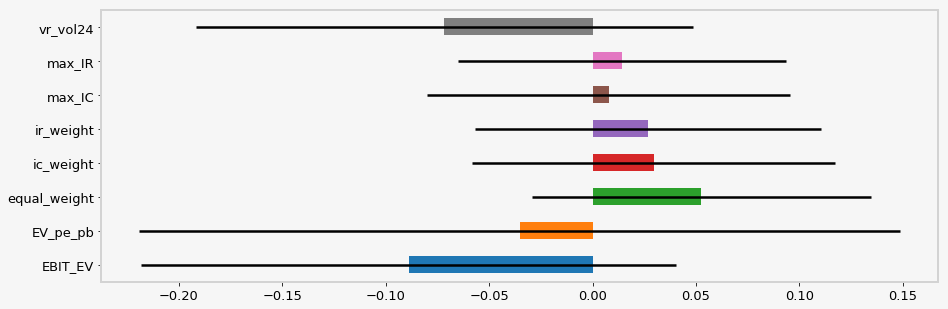

In [17]:
pd.Series(ic_20_mean).plot(kind="barh",xerr=pd.Series(ic_20_std),figsize=(15,5))

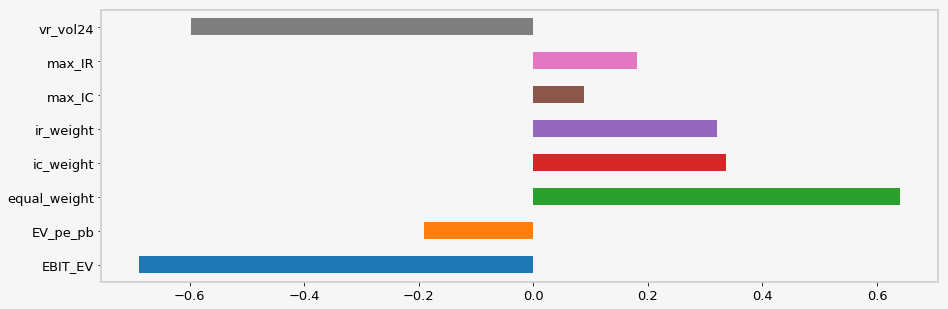

In [18]:
pd.Series(ir_20).plot(kind="barh",figsize=(15,5))

In [19]:
print(ic_20_mean["equal_weight"])
print(ic_20_mean["vr_vol24"])

0.052477213035894484
-0.07170214886395386


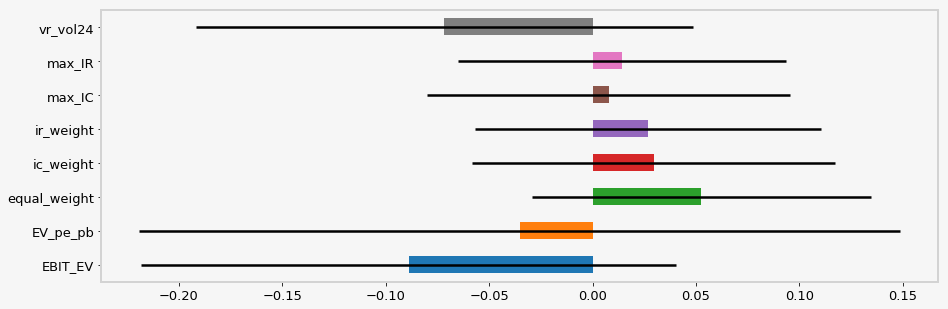

In [20]:
pd.Series(ic_20_mean).plot(kind="barh",xerr=pd.Series(ic_20_std),figsize=(15,5))

In [21]:
print(ir_20["equal_weight"])
print(ir_20["vr_vol24"])

0.6405075618334573
-0.5969776425477904


e:\python\lib\site-packages\jaqs\util\numeric.py:16: RuntimeWarning: divide by zero encountered in true_divide
  res = np.floor(rank / divisor) + 1.0
e:\python\lib\site-packages\jaqs\util\numeric.py:16: RuntimeWarning: invalid value encountered in true_divide
  res = np.floor(rank / divisor) + 1.0


Nan Data Count (should be zero) : 0;  Percentage of effective data: 73%


Value of signals of Different Quantiles Statistics
               min        max      mean       std  count    count %
quantile                                                           
1        -9.567370  -0.570064 -1.294328  0.817414  43628  20.055992
2        -0.694102  -0.108038 -0.385665  0.132760  43501  19.997610
3        -0.232892   0.228239  0.000962  0.103529  43511  20.002207
4         0.110224   0.705454  0.392881  0.134439  43501  19.997610
5         0.553959  10.385404  1.310454  0.764511  43390  19.946582
Figure saved: C:\Users\Administrator\Desktop\HelloGit-master\returns_report.pdf


e:\python\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
e:\python\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
e:\python\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
e:\python\lib\site-packages\jaqs_fxdayu\research\signaldigger\performance.py:69: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  grouper.append(pd.TimeGrouper(by_time))


Information Analysis
                 ic
IC Mean       0.052
IC Std.       0.082
t-stat(IC)   10.686
p-value(IC)   0.000
IC Skew      -0.534
IC Kurtosis  -0.429
Ann. IR       0.640


e:\python\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Figure saved: C:\Users\Administrator\Desktop\HelloGit-master\information_report.pdf


<Figure size 432x288 with 0 Axes>

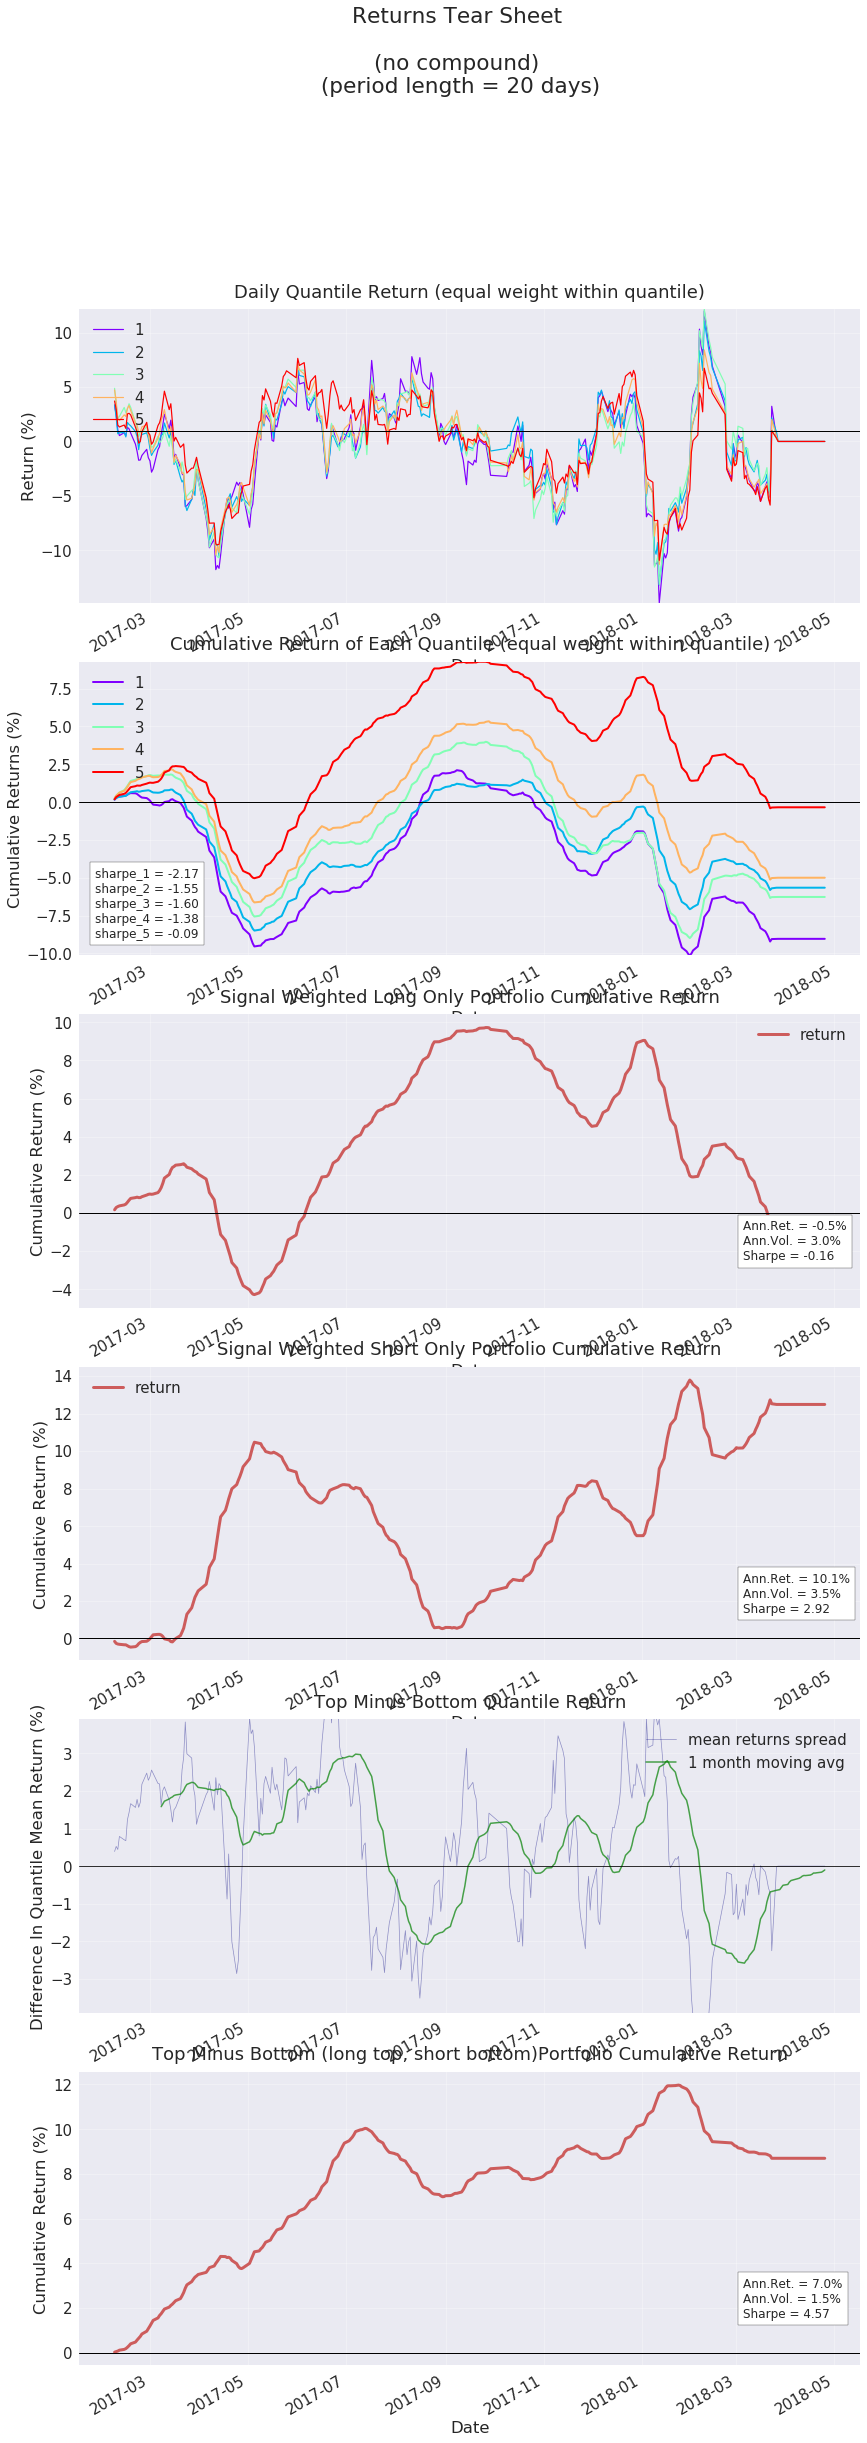

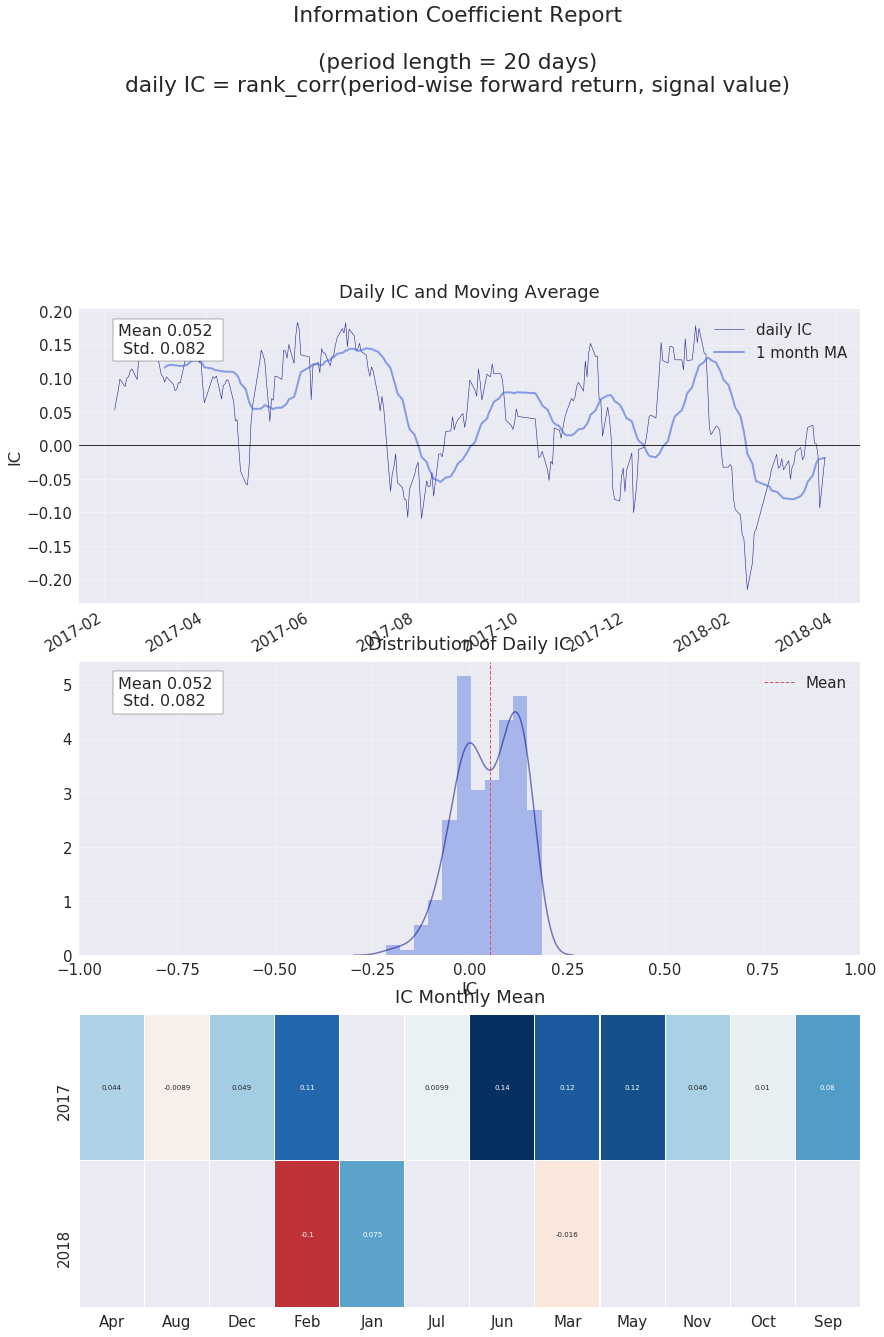

In [22]:
#查看等权合成因子的详情报告
import matplotlib.pyplot as plt
from jaqs_fxdayu.research.signaldigger.analysis import analysis
from jaqs_fxdayu.research import SignalDigger

obj = SignalDigger()
obj.process_signal_before_analysis(signal=comb_factors["equal_weight"],
                                   price=dv.get_ts("close_adj"),
                                   high=dv.get_ts("high_adj"), # 可为空
                                   low=dv.get_ts("low_adj"),# 可为空
                                   n_quantiles=5,# quantile分类数
                                   mask=mask,# 过滤条件
                                   can_enter=can_enter,# 是否能进场
                                   can_exit=can_exit,# 是否能出场
                                   period=20,# 持有期
                                   #benchmark_price=dv.data_benchmark, # 基准价格 可不传入，持有期收益（return）计算为绝对收益
                                   commission = 0.0008,
                                   )
obj.create_full_report()
plt.show()

In [23]:
#将Quantile5的选股结果保存成excel
excel_data = obj.signal_data[obj.signal_data['quantile']==5]["quantile"].unstack().replace(np.nan, 0).replace(5, 1)
print (excel_data.head())
excel_data.to_excel('./equal_weight_quantile_5.xlsx')

symbol      000001.SZ  000002.SZ  000006.SZ  000012.SZ  000021.SZ  000027.SZ  \
trade_date                                                                     
20170207          0.0        0.0        0.0        0.0        0.0        1.0   
20170208          0.0        0.0        0.0        0.0        0.0        1.0   
20170209          0.0        0.0        0.0        0.0        0.0        1.0   
20170210          0.0        0.0        0.0        0.0        0.0        1.0   
20170213          0.0        0.0        0.0        0.0        0.0        1.0   

symbol      000028.SZ  000039.SZ  000049.SZ  000050.SZ    ...      603568.SH  \
trade_date                                                ...                  
20170207          0.0        0.0        0.0        0.0    ...            0.0   
20170208          0.0        0.0        0.0        0.0    ...            0.0   
20170209          0.0        0.0        0.0        0.0    ...            0.0   
20170210          0.0        0.0       